# Sales Outreach Email Engagement Analysis 
Author: Sangy Hanumasagar, 30 April 2018 <br>
Python 3.6.2

## Table of Contents

#### Part I
1. Introduction 
2. Exploratory Data Analysis, Preprocessing and Feature Selecion

#### Part II
3. Class Imbalance
4. Imputing Missing Values
5. ML Model Comparison and Selection

#### Part III
5. Undersampling
6. Model Model Performance & Hyperparameter Tuning
7. Interpretation of Results and Feature Importance
8. Closing Thoughts

## Introduction: 
Predict whether a specific email will be enaged with or not. Engagement can be in the form of opening, clicking or in the best case, replyiong back. 

I will handle this as a classification problem, where the predicted classes denote specific email engagements.
I initially wanted to take 2 approaches: 
* binary classification (email opened [positive] or not[negative]) model 
* multi-class classification (email replied [class 3], opened [class 2] or ignored [class 1])
However, due to time constraints, I will only present the binary classification results. So, engagement, for the scope of this analysis, is limited to the case of the email being opened or not. 


The features in the dataset can be divided into 5 categories: 
* time-related 
* email-content-related 
* company-related 
* prospect-related 
* sequence-related

#### Going by intuition, we can list a few thoughts regarding the features which could  be influential:

1) day and time of email delivery coulb be crucial towards the email being opened

2) customization of email contents towards prospects specific goals for his/her company. However this is not scalable for sales reps.

3) subject length and body length- not too long!

4) no of follow ups to a prospect should increase chances of a response. However, too many emails could also prompt them to opt out. Here fields like opened at and clicked at are good indicators for prioritizing prospects

5) Prospect related features: occupation, persona, company tier industry (different industries operate differently). For example, sales representatives of established companies, who form the end users of Outreach software, probably show higher response rates. Tech/software companies are more likely to be open to integrating new tech in their workflow, so they are likely positive prospects as well.

5) Sequence related features: I am not entirely familiar with the specific features and differences between the various sequences/sequence templates. I will limit my analysis to the sequence order within each sequence, which captures the length of sequences. There are totally 50 sequence order numbers in the software. But I expect the interested prospects to enngage in early-mid range of a sequence.


In [1]:
#import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('bmh')

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
pd.set_option('display.max_columns',None) #prevents abbreviation of columns 
np.set_printoptions(precision=3)

## Exploratory Data Analysis
Let's read the csv data into a dataframe and explore the feature types.

In [4]:
full_df = pd.read_csv("sequence-mailings.csv",error_bad_lines=False,warn_bad_lines=False)

C:\Users\Sangy\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (2,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


I decided to remove entries where the number of features exceeded 44. These rows were only 65 in number, and also the immediate goal is to reach MVP stage. 
In these 65 dropped rows, the individual tags in the 'tags' field have been separated into separate columns creating additional header-less columns. I believe this error is not inherent to the data pipeline, but rather caused when a user opened the csv file in excel which separated the tags fields into different columns, user then saved the file

### Dataframe Info

In [5]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023256 entries, 0 to 1023255
Data columns (total 44 columns):
id                      1023256 non-null int64
message_id              1023256 non-null object
parent_message_id       732326 non-null object
to_domain               1023256 non-null object
from                    1023256 non-null object
is_thread_reply         1023256 non-null int64
subject_customized      1023256 non-null int64
body_customized         1023256 non-null int64
subject_length          454321 non-null float64
body_length             1012846 non-null float64
delivered_at            1023256 non-null object
thread_replied_at       33688 non-null object
replied_at              31137 non-null object
track_links             1023248 non-null float64
track_opens             1023248 non-null float64
includes_link           129 non-null float64
opened_at               277427 non-null object
clicked_at              3134 non-null object
mailbox_id              1023256 non-

In [6]:
#convert data-time columns to date-time objects
full_df['delivered_at']=pd.to_datetime(full_df['delivered_at'])
full_df['thread_replied_at']=pd.to_datetime(full_df['thread_replied_at'])
full_df['replied_at']=pd.to_datetime(full_df['replied_at'])
full_df['opened_at']=pd.to_datetime(full_df['opened_at'])
full_df['clicked_at']=pd.to_datetime(full_df['clicked_at'])
full_df['prospect_dob']=pd.to_datetime(full_df['prospect_dob'])
full_df['prospect_opted_out']=pd.to_datetime(full_df['prospect_opted_out'])


## ---------------------------------

#### Define target variable
##### Approach 1: Binary classification-email opened [1] or not opened [0]
* For this, I will make a column called "email_opened" [Note that emails opened is a superset of replied emails.] 
* I will also make a column called "email_replied" to indicate emails that have received replies.

In [7]:
#Lets create some useful columns

full_df['email_opened']=full_df['opened_at'].notnull().astype(int)
full_df['email_replied']=full_df['replied_at'].notnull().astype(int)

## ---------------------------------

### Preliminary Feature Selection

#### Preliminary observations:
* 'id' is just an indexing variable for the dataframe

* 'from' and 'mailbox_id' field (threse two are related) are not necessary as the stranger prospect has no idea who the person is.

* The to-domain field has a lot of unique values, captures how many companies have been previously contacted (and how many times)

* Prospect website, website, prospect first name are also not important

* if prospect opted out is not useful for the current goal of the study (which is to predict if an email will get a response).
(this would be useful if we're tring to predict behavior prior to opting out)

* I believe track links and track_opens and tags are internal trackers, so they shouldn't affect propsects opening the emails. we can drop them as well.
  
* message_id and parent_message_id are all unique and can be dropped

## ---------------------------------

#### Missing Values by percentage

<Container object of 46 artists>

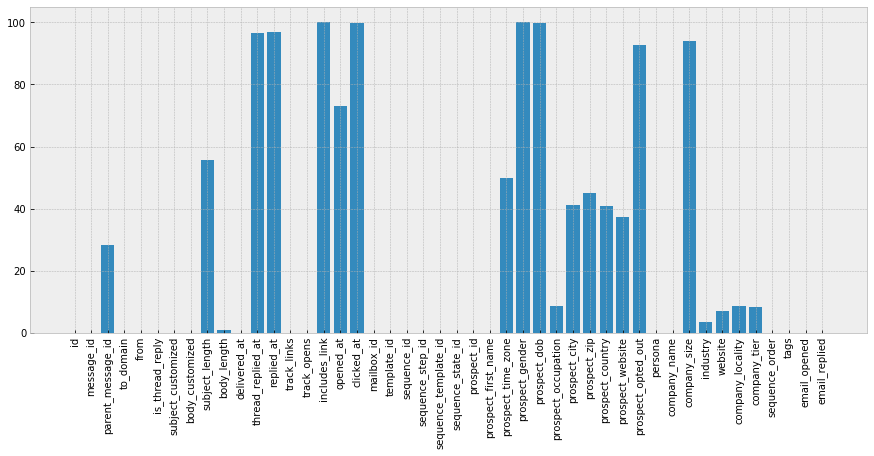

In [8]:
col=[]
#x=np.arange(len(full_df.select_dtypes(exclude=[np.datetime64])))
x=np.arange(len(full_df.columns))
val=[]
for column in full_df.columns:#select_dtypes(exclude=[np.datetime64]):
    col.append(column)
    val.append(round(full_df[column].isnull().sum()/len(full_df)*100,1))

plt.figure(figsize=(15,6))   
xticks=col
plt.xticks(x, xticks,rotation='vertical')
plt.bar(x,val)

From the above chart:

1) subject length, which we surmised could be useful, is unfortunately partally null

2) there are a lot of unreplied emails and fewer (but still significant) unopened emails. Since these form our target variables, we have to deal with class imbalance

3) prospect gender, prospect DOB and company size are mostly missing and also not significant and can be dropped. Company tier can replace company size

#### Let's remove the features which have been identified as unrelated or mostly absent. The resulting dataframe is as follows:

In [9]:
# First round of removing unnecessary fields
full_df.drop(['id','from','mailbox_id','to_domain','prospect_first_name','prospect_gender','prospect_dob','prospect_website',
              'website','prospect_opted_out','track_links','track_opens','tags','parent_message_id','message_id','company_size'],
             axis=1,inplace=True)
#'message_id','parent_message_id'
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023256 entries, 0 to 1023255
Data columns (total 30 columns):
is_thread_reply         1023256 non-null int64
subject_customized      1023256 non-null int64
body_customized         1023256 non-null int64
subject_length          454321 non-null float64
body_length             1012846 non-null float64
delivered_at            1023256 non-null datetime64[ns]
thread_replied_at       33688 non-null datetime64[ns]
replied_at              31137 non-null datetime64[ns]
includes_link           129 non-null float64
opened_at               277427 non-null datetime64[ns]
clicked_at              3134 non-null datetime64[ns]
template_id             1023256 non-null int64
sequence_id             1023256 non-null int64
sequence_step_id        1023256 non-null int64
sequence_template_id    1022726 non-null float64
sequence_state_id       1023256 non-null int64
prospect_id             1023256 non-null int64
prospect_time_zone      513022 non-null object
p

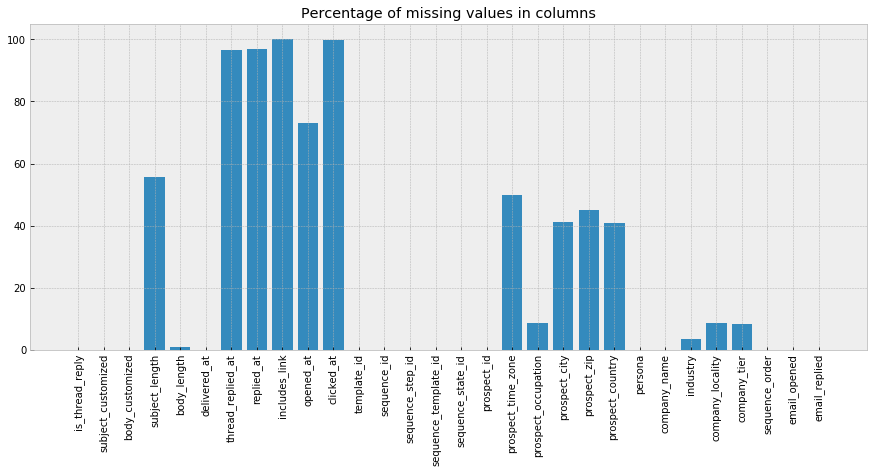

In [10]:
col=[]
#x=np.arange(len(full_df.select_dtypes(exclude=[np.datetime64])))
x=np.arange(len(full_df.columns))
val=[]
for column in full_df.columns:#select_dtypes(exclude=[np.datetime64]):
    col.append(column)
    val.append(round(full_df[column].isnull().sum()/len(full_df)*100,1))

plt.figure(figsize=(15,6))   
xticks=col
plt.xticks(x, xticks,rotation='vertical')
plt.bar(x,val)
plt.title('Percentage of missing values in columns')

## ---------------------------------

### EDA (continued)

#### We are now left with 30 features. These can broadly be divided into 5 categories:
#### |time-related | email-content-related | company-related | prospect-related | sequence-related |

## ---------------------------------

### Time related Features

#### Out of all delivered emails, how many were engaged? [opened, clicked and replied]

Email counts: 
 delivered_at    1023256
opened_at        277427
clicked_at         3134
replied_at        31137
dtype: int64


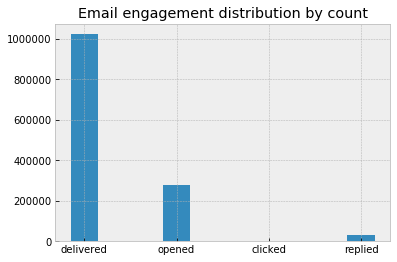

In [11]:
x=[1,2,3,4]
xticks=['delivered','opened','clicked','replied']
p1=plt.bar(x,list(full_df[['delivered_at','opened_at','clicked_at','replied_at']].count()),width=0.3)
plt.xticks(x, xticks)
plt.title('Email engagement distribution by count')
print('Email counts: \n',full_df[['delivered_at','opened_at','clicked_at','replied_at']].count())

* Totally, 277427 emails were opened [ 27% of delivered emails ]. 
* Totally, 31137 were replied [ 11.2% of opened emails, 3% of delivered emails]

##### Check:  all emails that have been replied to must be opened. Does data reflect this? 

In [12]:
#data integrity check - all emails that have been replied to must be opened!
emails_replied=full_df['replied_at'].count()
emails_replied_and_opened=full_df[full_df['replied_at'].notnull()]['opened_at'].notnull().sum()
print(emails_replied-emails_replied_and_opened," emails were repled to without opening, which could be a data error. However it is insignificant.")

9  emails were repled to without opening, which could be a data error. However it is insignificant.


#### How many clicks preceded replied?

In [13]:
print('Total replies: ', full_df['replied_at'].count())
no_clicked_and_replied=len(full_df[(full_df['replied_at'].notnull()) & (full_df['clicked_at'].notnull())])
print ('Total clicks before replies:',no_clicked_and_replied)

Total replies:  31137
Total clicks before replies: 917


##### Out of 31137 emails that were replied, 917 were clicked !  
##### Total no of clicks = 3134 => The remaining 2217 are  interested propsects who should be prioritized.

In [14]:
# In fact, some prospects have clicked on email links several times as shown below. 
# These prospects are prime candidates for a follow up phone call or other modes of communication.

interested_prospects=full_df[(full_df['clicked_at'].notnull())&(full_df['replied_at'].isnull())]
print("Some potential prospects who have clicked but not replied for prioritization: \n", interested_prospects.prospect_id.value_counts()[:5])

Some potential prospects who have clicked but not replied for prioritization: 
 26359    12
29785    12
35125    11
26064    10
26352    10
Name: prospect_id, dtype: int64


#### Anomaly with 'includes_link' field
I then explored the includes_link column, which could be used as an binary indicator field for interested prospects. However, as shown below, I noticed the 'includes_link column does not  accurately reflect the 'clicked_at' column. 

In [15]:
#First, lets investigate if 'clicked_at' column makes sense
print('No of emails that inlcudes link in the full dataset as per "includes_link" field: ',
      full_df['includes_link'].notnull().sum())

print('\n',full_df[(full_df['includes_link'].isnull()) & (full_df['clicked_at'].notnull())]
      [['delivered_at','includes_link','clicked_at']].tail())

print('\n No of entries where email includes no link but clicked_at is not null is: ', 
      len(full_df[(full_df['includes_link'].isnull()) & (full_df['clicked_at'].notnull())]))

No of emails that inlcudes link in the full dataset as per "includes_link" field:  129

                delivered_at  includes_link          clicked_at
1019581 2017-11-22 15:30:16            NaN 2017-11-22 15:30:26
1020150 2017-11-27 17:30:05            NaN 2017-11-27 17:30:11
1022304 2017-11-28 18:25:08            NaN 2017-11-28 18:25:30
1022953 2017-11-27 19:44:42            NaN 2017-11-27 20:36:16
1023131 2017-11-28 14:01:09            NaN 2017-11-28 14:01:41

 No of entries where email includes no link but clicked_at is not null is:  3129


The above cell tells us that:
* only 129 of all emails included link as per 'includes_link' field
* of the 3134 emails that were clicked in the full dataset, 3129 emails did not have a link. There is somcething wrong with either the 'includes_link' field or 'clicked_at' field. 

#### For this exercise, I will use the 'clicked_at' field and drop the includes_link field. 

In [16]:
full_df.drop(['includes_link'],axis=1,inplace=True)

## ---------------------------------

#### Make new fields for day of week and hour of day 
I will now extract day (0-6) and hour of day (0-23) for the datetime fields. These are repetitive variables and much easier for algorithms to extract patterns.

In [17]:
full_df['delivered_at_day']=full_df['delivered_at'].dt.dayofweek #weekday_name 
full_df['delivered_at_hour']=full_df['delivered_at'].dt.hour
full_df['opened_at_day']=full_df['opened_at'].dt.dayofweek
full_df['opened_at_hour']=full_df['opened_at'].dt.hour
full_df['replied_at_day']=full_df['replied_at'].dt.dayofweek
full_df['replied_at_hour']=full_df['replied_at'].dt.hour

Summary of datetime fields based on day of week:

In [18]:
full_df[['delivered_at_day','opened_at_day','replied_at_day']].describe()

,delivered_at_day,opened_at_day,replied_at_day
count,1.023256e+06,277427.000000,31137.000000
mean,1.950954e+00,1.914684,1.927578
std,1.683317e+00,1.673592,1.587481
min,0.000000e+00,0.000000,0.000000
25%,0.000000e+00,0.000000,0.000000
50%,2.000000e+00,2.000000,2.000000
75%,3.000000e+00,3.000000,3.000000
max,6.000000e+00,6.000000,6.000000


Summary of datetime fields based on hour of day:

In [19]:
full_df[['delivered_at_hour','opened_at_hour','replied_at_hour']].describe()

,delivered_at_hour,opened_at_hour,replied_at_hour
count,1.023256e+06,277427.000000,31137.000000
mean,1.286282e+01,13.604094,15.245721
std,6.634990e+00,6.313752,5.266495
min,0.000000e+00,0.000000,0.000000
25%,1.100000e+01,12.000000,14.000000
50%,1.400000e+01,15.000000,16.000000
75%,1.800000e+01,18.000000,19.000000
max,2.300000e+01,23.000000,23.000000


Note: I beleive all time fields are local time at Outreach (not based on prospect location). This is supported by the low number of email between 6-9 AM. Also, as shown earlier, half the timezone entries were missing and half the prospects are US-based. So this is a safe assumption.   

#### The following cells look at the frequency of email deliveries, opens and replies by day and hour
_(Note: This is not a stacked bar chart. The replied and delivered emails are correctly plotted as subsets of delivered emails.)_

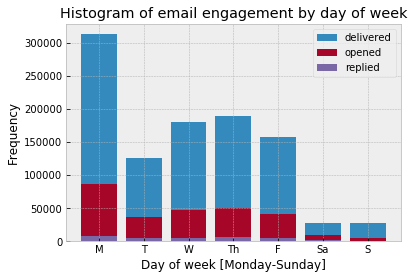

In [20]:
ax=full_df['delivered_at_day'].plot.hist(bins=[0,1,2,3,4,5,6,7],rwidth=0.8,label='delivered')
ax=full_df['opened_at_day'].plot.hist(bins=[0,1,2,3,4,5,6,7],rwidth=0.8,label='opened')
ax=full_df['replied_at_day'].plot.hist(bins=[0,1,2,3,4,5,6],rwidth=0.8,label='replied')
plt.title('Histogram of email engagement by day of week')
plt.xlabel('Day of week [Monday-Sunday]')
ax.set_xticks(np.arange(7)+0.5)
ax.set_xticklabels(['M','T','W','Th','F','Sa','S'])
plt.legend()

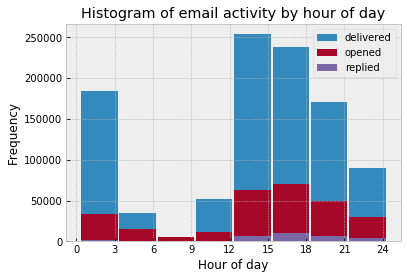

In [21]:
ax=full_df['delivered_at_hour'].plot.hist(bins=[0,3,6,9,12,15,18,21,24],align='mid',rwidth=0.95,label='delivered')
ax=full_df['opened_at_hour'].plot.hist(bins=[0,3,6,9,12,15,18,21,24],align='mid',rwidth=0.95,label='opened')
ax=full_df['replied_at_hour'].plot.hist(bins=[0,3,6,9,12,15,18,21,24],align='mid',rwidth=0.95,label='replied')
plt.title('Histogram of email activity by hour of day')
plt.xlabel('Hour of day')
#plt.xticks(ind, ('(14.0, 16.0]','(12.0, 14.0]','(16.0, 18.0]','(-0.001, 2.0]','(18.0, 20.0]','(20.0, 22.0]','(10.0, 12.0]','(2.0, 4.0]','(22.0, 24.0]','(8.0, 10.0]','(4.0, 6.0] ','(6.0, 8.0]'),rotation='vertical')
ax.set_xticks(np.array([0,3,6,9,12,15,18,21,24])-0.3)
ax.set_xticklabels(['0','3','6','9','12','15','18','21','24'])
plt.legend()

_The above cells indicate that all three fields show a similar trend, probably driven by email deliveries. However, we will only be using delivered in training, so don't have to worry about collinearity._

The field thread_replied_at is the same as replied_at and will be dropped.

In [22]:
#thread_replied at vs replied_at

print(np.mean(full_df['thread_replied_at']-full_df['replied_at']))
full_df.drop('thread_replied_at',axis=1,inplace=True)

0 days 00:00:00


## ---------------------------------

### Email-content-related Features

#### Does customizing the email contents have a positive effect towards engaging the prospect? 

In [23]:
print('\n Number of total emails that were replied: SUBJECT & BODY CUSTOMIZATION  ')
pd.crosstab(index=full_df['subject_customized'],columns=full_df['body_customized'])



 Number of total emails that were replied: SUBJECT & BODY CUSTOMIZATION  


body_customized,0,1
subject_customized,,
0,1011824,112
1,11303,17


These cells indicate customizing the body certainly isnt very significant.

However, subject customization may be a factor in getting emails opened. 
For example 277427 emails were opened in total, but of the 11320 emails where subject was customized, 4712 emails were opened.

## ---------------------------------


#### How does length of subject and body affect engagement?

In [24]:
print('Number of missing values in subject_length ad body_length fields:')
full_df['subject_length'].isnull().sum(),full_df['body_length'].isnull().sum()

Number of missing values in subject_length ad body_length fields:


(568935, 10410)

There are a lot of missing values in subject length, which needs to be addressed.

#### Histograms of subject and body length fields

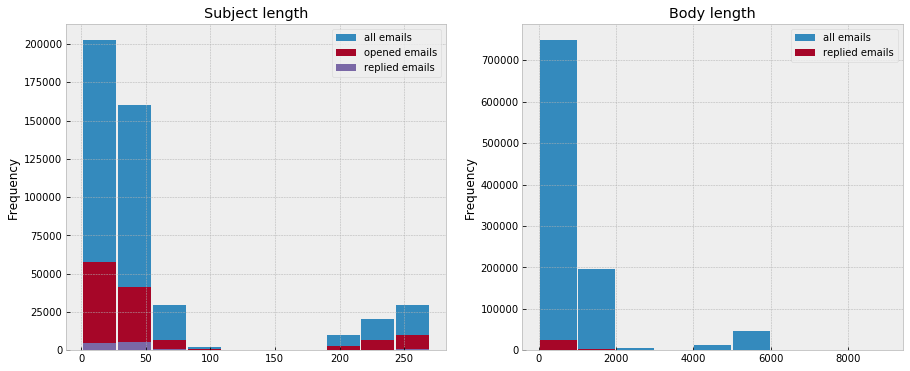

In [25]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.title('Subject length')
full_df['subject_length'].plot.hist(rwidth=0.95,label='all emails')
full_df[full_df['email_opened']==1]['subject_length'].plot.hist(rwidth=0.95,label='opened emails')
full_df[full_df['email_replied']==1]['subject_length'].plot.hist(rwidth=0.95,label='replied emails')
plt.legend()

plt.subplot(122)
plt.title('Body length')
full_df['body_length'].plot.hist(bins=np.arange(0,10000,1000),rwidth=0.95,label='all emails')
full_df[full_df['email_replied']==1]['body_length'].plot.hist(bins=np.arange(0,10000,1000),rwidth=0.95,label='replied emails')
plt.legend()

_Note: Body length is not a factor in relation to prospect opening email, hence not plotted in right-side chart_

In [26]:
print('When subject length is null:')
print('email opened value counts: \n',full_df[full_df.subject_length.isnull()].email_opened.value_counts())
print('\n When subject length is not null:')
print('email opened value counts: \n',full_df[full_df.subject_length.notnull()].email_opened.value_counts())

When subject length is null:
email opened value counts: 
 0    417458
1    151477
Name: email_opened, dtype: int64

 When subject length is not null:
email opened value counts: 
 0    328371
1    125950
Name: email_opened, dtype: int64


_ There are a significant of opened emails when subject-length is null. So imputing the missing values of subject length could  have a big effect on predictions. _

The following are the mean, median and mode values of the subject_length field. Using the mean for missing values isn't ideal due to above bimodal distribution. I might use the mode. 

In [27]:
print('Mean: ',round(full_df['subject_length'].mean(),0))
print('Median: ',full_df['subject_length'].median())
print('Mode: ',full_df['subject_length'].mode()[0])

Mean:  58.0
Median:  31.0
Mode:  13.0


## ---------------------------------

### Company related Features 
[company_name, industry, company_locality, company_tier]   

I will drop company_locality to start with as email engagement should not be geographically related.

#### Top 20 company localities:
Email engagement should not be geographically related but there might be some connections/network effects. However, the industry field should also capture locality, since industries tend to be concentrated in pockets.
From below, New York and SF are driving email enagements probably via tech companies.  

Top 20 email-opened events based on company locality-

In [28]:
full_df[full_df['email_opened']==1]['company_locality'].value_counts()[:20]

New York         17111
San Francisco    16033
Chicago           6634
Austin            5135
Boston            4003
San Jose          3965
Atlanta           3640
Mountain View     3178
Santa Clara       2874
San Diego         2856
Redwood City      2765
Seattle           2720
Los Angeles       2646
Palo Alto         2627
Denver            2467
Houston           2445
Sunnyvale         2444
Dallas            2308
San Mateo         2119
Irvine            1829
Name: company_locality, dtype: int64

In [29]:
full_df.drop('company_locality',axis=1,inplace=True)

#### Company names

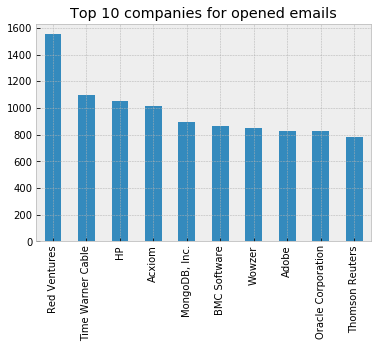

In [30]:
plt.title('Top 10 companies for delivered emails')
full_df['company_name'].value_counts()[:10].plot('bar')

plt.title('Top 10 companies for opened emails')
#full_df[full_df['email_opened']==1]['company_name'].value_counts()[:10]

#### Company Tier

I will group SMB, 201-1000 and Undefined into "Other" cateogry

In [31]:
#Lets group SMB, 201-1000 and Undefined into Other cateogry

full_df.loc[(full_df['company_tier']=='SMB')|(full_df['company_tier']=="201-1000")|(full_df['company_tier']=="Undefined"),'company_tier']="Other"

In [32]:
full_df['company_tier'].value_counts()

Mid-Market        508914
Enterprise        140250
Commercial        128081
Strategic          87564
Small Business     69367
Other               5250
Name: company_tier, dtype: int64

In [33]:
#full_df.groupby('company_tier').email_opened.sum()

Lets plot the emails delivered and oened based on company tiers. <br>
_ Midmarket and small businesses are relatively more responsive than the rest._


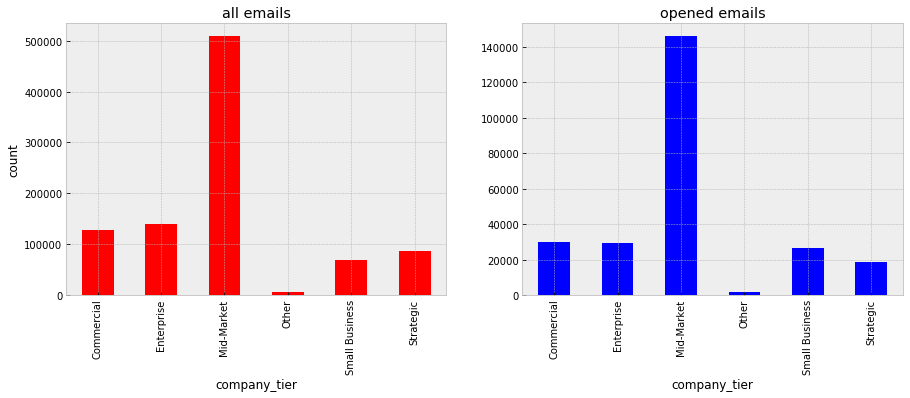

In [34]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('all emails')
ax=full_df.groupby('company_tier').email_opened.count().plot('bar',color='r')
plt.ylabel('count')
plt.subplot(122)
ax=full_df.groupby('company_tier').email_opened.sum().plot('bar',color='b')
plt.title('opened emails')


#### Industry

Most Popular Industries based on delivered emails:

In [35]:
full_df['industry'].value_counts()[:5]

Computer Software                      182750
Information Technology and Services    150855
Marketing and Advertising               64996
Internet                                55398
Financial Services                      54725
Name: industry, dtype: int64

Industries with most email-opened counts:

In [36]:
#which industry do the most successful emails belong to?
for ind in full_df['industry'].value_counts().keys()[:10]:
    print(ind,': ',full_df[full_df['industry']==ind].email_opened.sum())


Computer Software :  56030
Information Technology and Services :  38811
Marketing and Advertising :  19182
Internet :  23264
Financial Services :  11534
Telecommunications :  8095
Insurance :  4695
Staffing and Recruiting :  5603
Hospital & Health Care :  3819
Business Supplies and Equipment :  4327


There a lot categories in this field, and encoding all of them could diminish model performance. I will create a new field -'industy_category' with three categories by binning as follows: <br>
* tech:  software, IT, internet,Computer & Network Security, Computer Networking,Software Development & Design
* marketing: Marketing and Advertising 
* others: the rest
We can then one-hot encode these categories.

In [37]:
full_df['industy_category']=np.zeros(len(full_df))
full_df['industy_category']='other'
full_df['industy_category'].loc[(full_df['industry'] == 'Computer Software')| (full_df['industry'] =='Information Technology and Services') | 
                                       (full_df['industry'] =='Internet')|(full_df['industry'] =='Computer & Network Security')|
                                (full_df['industry'] =='Computer Networking')|(full_df['industry']=='Software Development & Design')]='tech'

full_df['industy_category'].loc[(full_df['industry'] == 'Marketing and Advertising')]='marketing'
full_df['industy_category'].value_counts()


C:\Users\Sangy\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


other        541951
tech         416309
marketing     64996
Name: industy_category, dtype: int64

## ---------------------------------

### Prospect related Features 
[persona, occupation, prospect_country]         

#### Persona

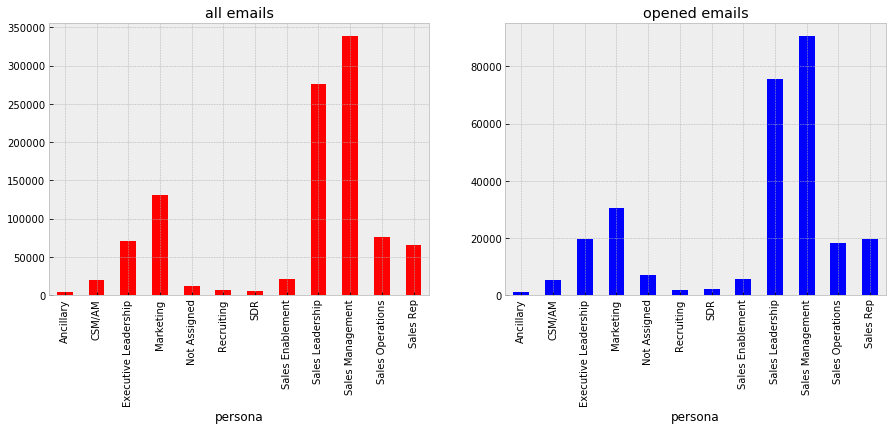

In [38]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('all emails')
ax=full_df.groupby('persona').email_opened.count().plot('bar',color='r')
plt.subplot(122)
ax=full_df.groupby('persona').email_opened.sum().plot('bar',color='b')
plt.title('opened emails')


#### Prospect Country 
About 40% of the prospect_country field is missing and close to 57% of the prospects are from the US. So this isnt vary valuable in predicting the email engagement. 

In [39]:
#half the dataset does not have information about prospect country.
print('Missing values: ',full_df['prospect_country'].isnull().sum())

Missing values:  418305


In [40]:
print('Value counts')
full_df['prospect_country'].value_counts().sort_values(ascending=False)[:10]

Value counts


United States     582084
United Kingdom      4907
Canada              4091
India               1641
France               994
Germany              960
Netherlands          940
Israel               914
Switzerland          724
Sweden               520
Name: prospect_country, dtype: int64

#### prospect_occupation vs industry - Repeated fields

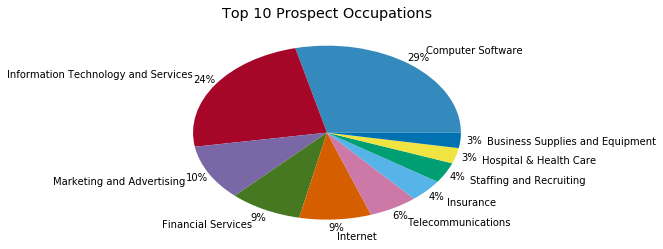

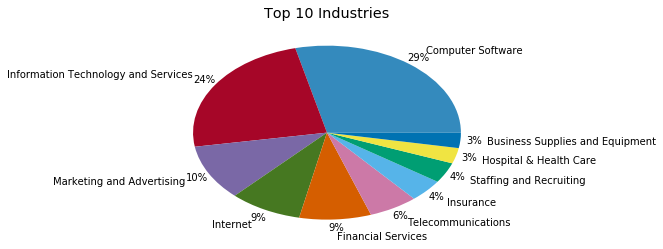

In [41]:
#prospect_occupation vs industry
occu=full_df['prospect_occupation'].value_counts().sort_values(ascending=False).tolist()[:10]
top10occ=full_df['prospect_occupation'].value_counts().sort_values(ascending=False).keys()[:10]
plt.title('Top 10 Prospect Occupations')
plt.pie(occu, labels=top10occ, autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
plt.show()

persona=full_df['industry'].value_counts(ascending=False).tolist()[:10]
top10industry=full_df['industry'].value_counts().sort_values(ascending=False).keys()[:10]
plt.title('Top 10 Industries')
plt.pie(occu, labels=top10industry, autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
plt.show()

We can now drop 'prospect_occupation','prospect_country','prospect_city','prospect_zip','prospect_time_zone'

In [42]:
#lets drop industry as we will use is_tech_industry instead
#also drop prospect country

full_df.drop(['prospect_occupation','prospect_country','prospect_city','prospect_zip','prospect_time_zone'],axis=1,inplace=True)

#### Prospect reply history
Many prospects are contacted multiple times. having a field showing the number of previous replies could be a useuful indicator for buildng a precitor model.

_ This feature is not intended for generalizing for all prospects. Rather, if emailing a previously contacted propsect, which is very common in this dataset, it can be useful.  _

#### It is important to note that out of 1M emails sent out, we have about 115740 unique prospects
#### There is no value in repeatedly emailing prospects if they are not replying. Instead, having a field showing how many time the prospect has previosuly replied would be beneficial for the sales rep. 

In [43]:
print('No of unique prospects: ',len(full_df['prospect_id'].unique()))

No of unique prospects:  115743


Top replying prospects:

In [44]:
prospect_history=full_df.groupby('prospect_id').email_replied.sum().sort_values(ascending=False)
prospect_history=prospect_history.reset_index()
prospect_history.columns=(['prospect_id','prospect_number_replies'])
prospect_history.head()

,prospect_id,prospect_number_replies
0,11942,20
1,69383,19
2,39012,16
3,3755,15
4,38189,15


In [45]:
full_df=full_df.merge(prospect_history, how='outer',on='prospect_id')

In [46]:
#we can now remove prospect id field
full_df.drop(['prospect_id'],axis=1,inplace=True)

## ---------------------------------

### Before, looking at sequence related features, lets look at the correlation heatmap below.

#### Lets plot a correlation heatmap using spearmans correlation since most of the fields are ranked ordinal. This will help us in identifying collinear features and subsequent feature selection.  

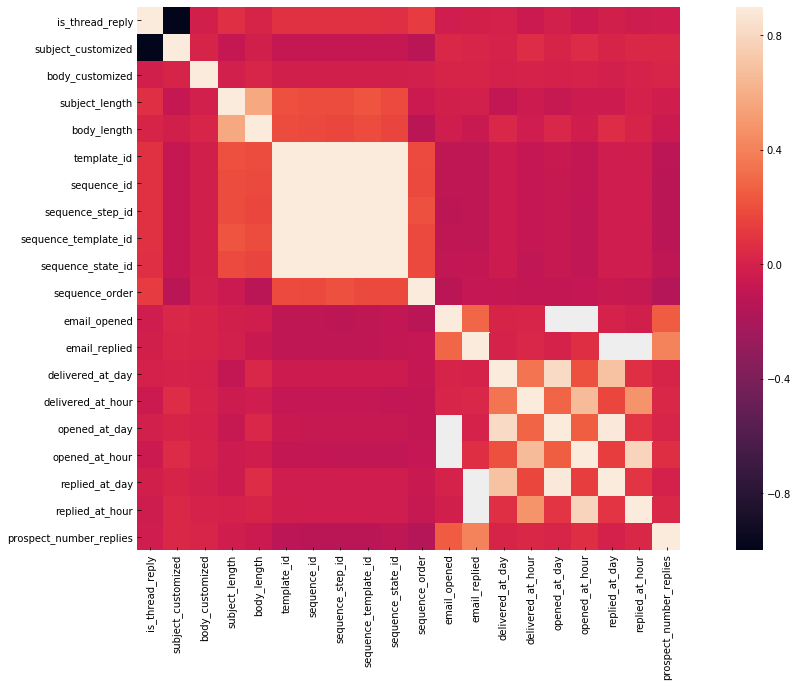

In [47]:
corrmat = full_df.corr(method='spearman')
plt.subplots(figsize=(20, 10))
sns.heatmap(corrmat, vmax=.9, square=True)

* Spearman's correlation determines the degree to which a relationship is monotonic. The sequence related features are showing high corrlation and therefore should be monotonic looking at the heat map. We will check using scatter plots below.
So we won't need all these for model training.

* Also, the time related features and the dependent columns are correlated as expected

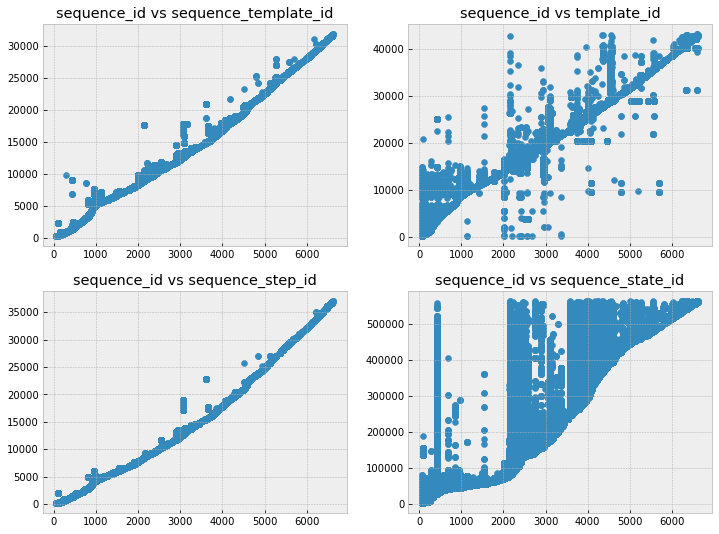

In [48]:
plt.figure(figsize=(12,9))
plt.subplot(221)
plt.title('sequence_id vs sequence_template_id')
plt.scatter(full_df['sequence_id'],full_df['sequence_template_id'])
plt.subplot(222)
plt.title('sequence_id vs template_id')
plt.scatter(full_df['sequence_id'],full_df['template_id'])
plt.subplot(223)
plt.title('sequence_id vs sequence_step_id')
plt.scatter(full_df['sequence_id'],full_df['sequence_step_id'])
plt.subplot(224)
plt.title('sequence_id vs sequence_state_id')
plt.scatter(full_df['sequence_id'],full_df['sequence_state_id'])


## Sequence related features
template_id, sequence_id, sequence_step_id,sequence_template_id, sequence_state_id, sequence_order


In [49]:
df_sequence=full_df[['template_id','sequence_id','sequence_step_id','sequence_template_id','sequence_state_id',
                            'sequence_order','email_opened']]

for field in df_sequence.columns:
    print('No of unique ',field,'entries= ',len(df_sequence[field].unique()))


No of unique  template_id entries=  10449
No of unique  sequence_id entries=  1092
No of unique  sequence_step_id entries=  5037
No of unique  sequence_template_id entries=  6666
No of unique  sequence_state_id entries=  210675
No of unique  sequence_order entries=  36
No of unique  email_opened entries=  2


Typically fields with large number of unique variables, lead to overfitting. Knowledge about the various id's could help in alleviating this problem. For example, binning multiple ids into a similar category would help the classifier.


Couple of thoughts:

1)Among the 6 sequence related features, sequence order could be used to capture the numer of times a prospect has been contacted prior in a particular sequence. 

2) Additionally, many prospects are part of multiple sequences. So, a feature, indicating whther a prospect has either replied or clicked on a link in the past (binary category) could be useful 

3) I am wary about using these features (seqeunce id,template id, sequence template id or sequence step id) directly in training  since they could lead to overfitting owing to large cardinality. Moreover I don't know the software design aspects of them. 

Sequence_order is a measure of length of a sequence. However, it is not continuous from 1 -49. There are only 36 unique seqeunce order values in the data 

In [50]:
df_sequence['sequence_order'].value_counts(bins=[0,10,20,30,40,50])

(-0.001, 10.0]    907673
(10.0, 20.0]      110881
(20.0, 30.0]        4009
(30.0, 40.0]         488
(40.0, 50.0]         205
Name: sequence_order, dtype: int64

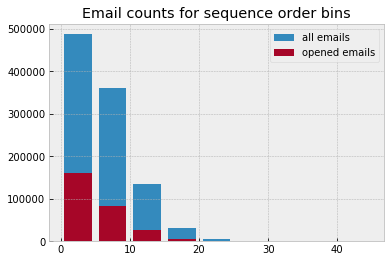

In [51]:
plt.title('Email counts for sequence order bins')
plt.hist(df_sequence['sequence_order'],bins=np.arange(0,50,5),rwidth=0.8,label='all emails')
plt.hist(df_sequence[df_sequence['email_opened']==1]['sequence_order'],bins=np.arange(0,50,5),rwidth=0.8,label='opened emails')
plt.legend()

Smaller sequences are favored in the data

In [52]:
del df_sequence

#### Observations re. sequences

1) Each individual instance of seqeunce (chain of emails) with a prospect is denoted by a unique seqeunce_state id

2) Sequence_id is repeated across prospects (not unique)

3) If a prospect replied, that denotes the end of a sequence 

In [53]:
max(full_df.groupby('sequence_state_id').email_replied.sum())

1

4) Some sequence-ids are more frequent than others as per the value counts below

In [54]:

full_df.groupby('sequence_id').email_replied.count().sort_values(ascending=False)[:10]

sequence_id
3098    124255
3100     58013
3102     56367
4046     39966
256      30664
3737     29818
4540     29412
4071     28814
2012     25205
3744     20737
Name: email_replied, dtype: int64

##### Feature engineering for sequences:
For each prospect, I will make a field called length of the sequence (or mean for prospcts with multiple sequences. This indicates the readiness of prospect to engage with the email. 

Higher the sequence length, the less likely the prospect is to reply (since the mean seq length is only 5 emails)


In [55]:
#how often were prospects contacted
seq_followups_df=full_df.groupby('sequence_state_id').sequence_order.count().sort_values(ascending=False)
seq_followups_df=seq_followups_df.reset_index()
seq_followups_df.columns=(['sequence_state_id','sequence_length'])
seq_followups_df.head()

,sequence_state_id,sequence_length
0,419814,25
1,417729,25
2,418652,25
3,415767,25
4,410093,25


#### Sequence length description
Obtained by grouping data by sequence state it (since it is unique for a sequence): 

count    210675.000000
mean          4.857036
std           3.184158
min           1.000000
25%           2.000000
50%           5.000000
75%           7.000000
max          25.000000
Name: sequence_length, dtype: float64


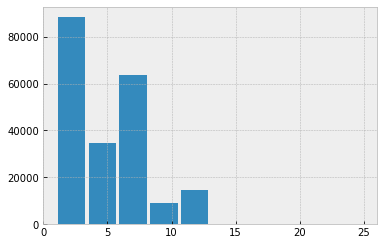

In [56]:
print(seq_followups_df.sequence_length.describe())
seq_followups_df.sequence_length.hist(rwidth=0.9)

##### Seqeunce are typically short ranging between 1-10 emails per sequence. So emails beyond this value are less likely to get a reposnse. So sales personnel can focus on other prospects, especially if the prospect hasn't previously engaged positively.  

In [57]:
full_df=full_df.merge(seq_followups_df, how='outer',on='sequence_state_id')

I will drop the other sequence related features for now, keeping only sequence length and sequence_id

In [58]:
full_df.drop(['sequence_state_id','sequence_step_id','sequence_template_id','template_id','sequence_order'],
             axis=1,inplace=True)

## ---------------------------------

### Lets now take a look at the dataframe

In [59]:
full_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1023256 entries, 0 to 1023255
Data columns (total 25 columns):
is_thread_reply            1023256 non-null int64
subject_customized         1023256 non-null int64
body_customized            1023256 non-null int64
subject_length             454321 non-null float64
body_length                1012846 non-null float64
delivered_at               1023256 non-null datetime64[ns]
replied_at                 31137 non-null datetime64[ns]
opened_at                  277427 non-null datetime64[ns]
clicked_at                 3134 non-null datetime64[ns]
sequence_id                1023256 non-null int64
persona                    1023256 non-null object
company_name               1022356 non-null object
industry                   987681 non-null object
company_tier               939426 non-null object
email_opened               1023256 non-null int32
email_replied              1023256 non-null int32
delivered_at_day           1023256 non-null int64
de

#### We will store this dataframe for importing into another notebook

In [60]:
%store full_df

Stored 'full_df' (DataFrame)


=========================================================================================================================